<a href="https://colab.research.google.com/github/KatherineElkins/programming-humanity-2025/blob/main/miniproject_2_sentimentarcs_simplified_20251109.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SentimentArcs Simplified Notebook

Created:

* 28 Oct 2022
* 30 Oct 2025
* Jon Chun

A simplified version of SentimentArcs Notebooks with only the most common and state-of-the-art sentiment analysis models in the ensemble. This operationalizes SentimentArcs more accessible and robust.

* https://github.com/jon-chun/sentimentarcs_notebooks

* https://arxiv.org/pdf/2110.09454.pdf

# Review VM Specs

In [ ]:
# Make sure your Linux VM is connected to a GPU

!nvidia-smi

Thu Nov 13 16:50:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   76C    P0             36W /   72W |    1229MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Check how many CPU cores available for parallization

!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 7
microcode	: 0xffffffff
cpu MHz		: 2200.216
cache size	: 39424 KB
physical id	: 0
siblings	: 12
core id		: 0
cpu cores	: 6
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch ssbd ibrs ibpb stibp ibrs_enhanced fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat avx512_vnni md_clear arch_capabilities
bugs		: spectre_v1 spectre_v2 spec_store_bypass swapgs taa mmio_stale_da

In [ ]:
!lscpu

Architecture:                x86_64
  CPU op-mode(s):            32-bit, 64-bit
  Address sizes:             46 bits physical, 48 bits virtual
  Byte Order:                Little Endian
CPU(s):                      12
  On-line CPU(s) list:       0-11
Vendor ID:                   GenuineIntel
  Model name:                Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:              6
    Model:                   85
    Thread(s) per core:      2
    Core(s) per socket:      6
    Socket(s):               1
    Stepping:                7
    BogoMIPS:                4400.43
    Flags:                   fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pg
                             e mca cmov pat pse36 clflush mmx fxsr sse sse2 ss h
                             t syscall nx pdpe1gb rdtscp lm constant_tsc rep_goo
                             d nopl xtopology nonstop_tsc cpuid tsc_known_freq p
                             ni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2ap
                 

# Setup

## Install Libraries

In [ ]:
# !pip install transformers[sentencepiece]

# !pip install transformers

## Import Libraries

In [ ]:
from google.colab import files

In [ ]:
import numpy as np
import pandas as pd
# import modin.pandas as pd_modin
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import re
import os

from tqdm import tqdm
import tqdm.notebook as tq
# for i in tq.tqdm(...):

## Configure Settings

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Global Variables & Functions

## Global Variables

In [ ]:
# Main (Modin) DataFrame for Novel Sentiments

sentiment_df = pd.DataFrame


## Common Functions

In [ ]:
def verify_novel(novel_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Name: {novel_name_str}')
  print(f'  Char Len: {len(novel_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {novel_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {novel_str[-index_ends:]}\n\n')

In [ ]:
def save_text2txt_and_download(text_obj, file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  out_filename = novel_name_str.split('.')[0] + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [ ]:
def save_df2csv_and_download(df_obj, file_suffix='_save.csv', nodate=True):
  '''
  INPUT: DataFrame object and suffix to add to output csv filename
  OUTPUT: Write DataFrame object to csv file (both temp VM and download)
  '''

  if isinstance(df_obj, pd.DataFrame):
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
      out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
      out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
    # print(f'STEP 1. Saving DataFrame: {df_obj.__name__} to temporary VM file: {out_filename}\n') # Also, isinstance(obj, pd.DataFrame)
    print(f'STEP 1. Saving DataFrame to temporary VM file: {out_filename}\n')
    df_obj.to_csv(out_filename, index=False)
  else:
    print(f'ERROR: Object is not a DataFrame [save_df2csv_and_download()]')
    return -1

  # Download permanent copy of file
  print(f'STEP 2. Downloading permanent copy of csvfile: {out_filename}\n')
  files.download(out_filename)


# Test

# save_df2csv_and_download(temp_df, '_bert-nlptown.txt')

# Get Clean Text

## Option (a): Clean Text

### Upload Raw Text File

Get plain text of familiar novel at:
* https://gutenberg.net.au/ (AUS)
* https://gutenberg.org/ (US)

In [ ]:
TEXT_ENCODING = 'utf-8'

In [ ]:
%%time

# NOTE: 1m07s

# Upload Plain Text File
novel_name_str = ''
uploaded = files.upload()

# NOTE: Allows for multiple file uploads, will only process the last
#       Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  novel_name_str = fn

# Extract from Dict and decode binary into char string
novel_raw_str = uploaded[novel_name_str].decode(TEXT_ENCODING)

Saving to_the_lighthouse.txt to to_the_lighthouse (1).txt
User uploaded file "to_the_lighthouse (1).txt" with length 382482 bytes
CPU times: user 88.6 ms, sys: 19.6 ms, total: 108 ms
Wall time: 40.7 s


In [ ]:
# Verify

verify_novel(novel_raw_str)

Novel Name: to_the_lighthouse (1).txt
  Char Len: 382482

Beginning:

 




THE WINDOW


1


"Yes, of course, if it's fine tomorrow," said Mrs. Ramsay. "But you'll
have to be up with the lark," she added.

To her son these words conveyed an extraordinary joy, as if it were
settled, the expedition were bound to take place, and the wonder to which
he had looked forward, for years and years it seemed, was, after a night's
darkness and a day's sail, within touch. Since he belonged, even at the
age of six, to that great clan which cannot keep this feeling separate
from 



------------------------------------
Ending:

 nes running up and across, its attempt at something. It
would be hung in the attics, she thought; it would be destroyed. But
what did that matter? she asked herself, taking up her brush again.
She looked at the steps; they were empty; she looked at her canvas; it
was blurred. With a sudden intensity, as if she saw it clear for a
second, she drew a line there, in the centre. I

### Clean Text

In [ ]:
!pip install clean-text

In [ ]:
!pip install unidecode  # clean-text dependency

In [ ]:
from cleantext import clean

In [ ]:
novel_clean_str = clean(novel_raw_str,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    # replace_with_punct="",          # instead of removing punctuations you may replace them
    # replace_with_url="<URL>",
    # replace_with_email="<EMAIL>",
    # replace_with_phone_number="<PHONE>",
    # replace_with_number="<NUMBER>",
    # replace_with_digit="0",
    # replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)

# Replace all new lines/returns with single whitespace
novel_clean_str = novel_clean_str.replace('\n\r', ' ')
novel_clean_str = novel_clean_str.replace('\n', ' ')
novel_clean_str = novel_clean_str.replace('\r', ' ')
novel_clean_str = ' '.join(novel_clean_str.split())
novel_clean_str

'the window 1 "yes, of course, if it\'s fine tomorrow," said mrs. ramsay. "but you\'ll have to be up with the lark," she added. to her son these words conveyed an extraordinary joy, as if it were settled, the expedition were bound to take place, and the wonder to which he had looked forward, for years and years it seemed, was, after a night\'s darkness and a day\'s sail, within touch. since he belonged, even at the age of six, to that great clan which cannot keep this feeling separate from that, but must let future prospects, with their joys and sorrows, cloud what is actually at hand, since to such people even in earliest childhood any turn in the wheel of sensation has the power to crystallise and transfix the moment upon which its gloom or radiance rests, james ramsay, sitting on the floor cutting out pictures from the illustrated catalogue of the army and navy stores, endowed the picture of a refrigerator, as his mother spoke, with heavenly bliss. it was fringed with joy. the wheel

In [ ]:
# Verify

verify_novel(novel_clean_str, index_ends=500)

Novel Name: to_the_lighthouse (1).txt
  Char Len: 381821

Beginning:

 the window 1 "yes, of course, if it's fine tomorrow," said mrs. ramsay. "but you'll have to be up with the lark," she added. to her son these words conveyed an extraordinary joy, as if it were settled, the expedition were bound to take place, and the wonder to which he had looked forward, for years and years it seemed, was, after a night's darkness and a day's sail, within touch. since he belonged, even at the age of six, to that great clan which cannot keep this feeling separate from that, but 



------------------------------------
Ending:

 s lines running up and across, its attempt at something. it would be hung in the attics, she thought; it would be destroyed. but what did that matter? she asked herself, taking up her brush again. she looked at the steps; they were empty; she looked at her canvas; it was blurred. with a sudden intensity, as if she saw it clear for a second, she drew a line there, in the centr

### [CAUTION] Trim Header & Footer

**CAUTION:** This requires manually adjusting the RegEx expressions to identify boundries between the header-novel (header_end_re) and the novel-footer (footer_start_re).

It is usually faster and more efficient to manually download, trim header/footer and upload a clean plain text file than use this procedure.

In [ ]:
# **DELETE** trim_header_footer()

novel_trim_str = novel_clean_str

**DELETED**: Section to automatically trim Gutenberg.org HEADER and FOOTER

In [ ]:
# Verify

verify_novel(novel_trim_str, 500)

Novel Name: to_the_lighthouse (1).txt
  Char Len: 381821

Beginning:

 the window 1 "yes, of course, if it's fine tomorrow," said mrs. ramsay. "but you'll have to be up with the lark," she added. to her son these words conveyed an extraordinary joy, as if it were settled, the expedition were bound to take place, and the wonder to which he had looked forward, for years and years it seemed, was, after a night's darkness and a day's sail, within touch. since he belonged, even at the age of six, to that great clan which cannot keep this feeling separate from that, but 



------------------------------------
Ending:

 s lines running up and across, its attempt at something. it would be hung in the attics, she thought; it would be destroyed. but what did that matter? she asked herself, taking up her brush again. she looked at the steps; they were empty; she looked at her canvas; it was blurred. with a sudden intensity, as if she saw it clear for a second, she drew a line there, in the centr

### Segment Text

In [ ]:
!pip install pysbd  # Python Sentence Boundry Detection

In [ ]:
import pysbd

In [ ]:
# FIX: Normally assigned within the 'Trim Header & Footer' Section

# Ensure we have trimmed version of novel in novel_trim_str

if len(novel_trim_str) > 0:
  # Header/Footer already trimmed from body of Novel
  pass
else:
  novel_trim_str = novel_raw_str

In [ ]:
%%time

# NOTE: 1m05s
#       2m38s for To the Lighthouse by Virginia Woolf

# Split Novel into Segments (~Sentences)
seg = pysbd.Segmenter(language="en", clean=False)
novel_segments_ls = seg.segment(novel_trim_str)

CPU times: user 1min 23s, sys: 21 ms, total: 1min 23s
Wall time: 1min 23s


In [ ]:
# Trim any leading/trailing whitespace on all Sentences

novel_clean_ls = [x.strip() for x in novel_segments_ls]

In [ ]:
# Verify

verify_novel(novel_clean_ls, 10)

Novel Name: to_the_lighthouse (1).txt
  Char Len: 3019

Beginning:

 ['the window 1 "yes, of course, if it\'s fine tomorrow," said mrs. ramsay.', '"but you\'ll have to be up with the lark," she added.', "to her son these words conveyed an extraordinary joy, as if it were settled, the expedition were bound to take place, and the wonder to which he had looked forward, for years and years it seemed, was, after a night's darkness and a day's sail, within touch.", 'since he belonged, even at the age of six, to that great clan which cannot keep this feeling separate from that, but must let future prospects, with their joys and sorrows, cloud what is actually at hand, since to such people even in earliest childhood any turn in the wheel of sensation has the power to crystallise and transfix the moment upon which its gloom or radiance rests, james ramsay, sitting on the floor cutting out pictures from the illustrated catalogue of the army and navy stores, endowed the picture of a refrigerator,

In [ ]:
# Save to file and download copy

save_text2txt_and_download(novel_clean_ls, '_segments.txt')

STEP 1. Processing List of Strings Object

STEP 2. Saving textfile to temporary VM file: to_the_lighthouse (1)_segments.txt

STEP 3. Downloading permanent copy of textfile: to_the_lighthouse (1)_segments.txt



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Populate novel sentiment_df with sentence number and clean segmented strings

sentence_no_ls = list(range(len(novel_clean_ls)))
sentence_no_ls[-1]

sentiment_df = pd.DataFrame({'line_no':sentence_no_ls, 'line':novel_clean_ls})
sentiment_df.head()

3018

,line_no,line
0,0,"the window 1 ""yes, of course, if it's fine tom..."
1,1,"""but you'll have to be up with the lark,"" she ..."
2,2,to her son these words conveyed an extraordina...
3,3,"since he belonged, even at the age of six, to ..."
4,4,it was fringed with joy.


## Option (b): Read Clean Text from File

# Compute Sentiment

## Option (1): Symbolic: Lexicons

### VADER

In [ ]:
!pip install vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()

In [ ]:
sentiment_vader_ls = [sid_obj.polarity_scores(asentence)['compound'] for asentence in novel_clean_ls]

In [ ]:
# Create new VADER DataFrame to save results

vader_df = sentiment_df[['line_no', 'line']].copy(deep=True)
vader_df['sentiment'] = pd.Series(sentiment_vader_ls)
vader_df.head()

,line_no,line,sentiment
0,0,"the window 1 ""yes, of course, if it's fine tom...",0.5423
1,1,"""but you'll have to be up with the lark,"" she ...",0.0000
2,2,to her son these words conveyed an extraordina...,0.4215
3,3,"since he belonged, even at the age of six, to ...",0.9631
4,4,it was fringed with joy.,0.5859


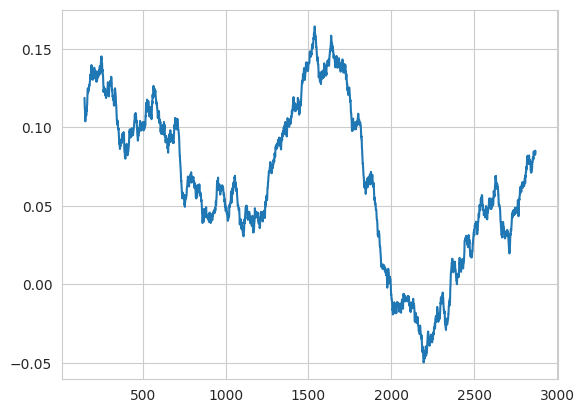

In [ ]:
win_per = 0.1
win_size = int(win_per * vader_df.shape[0])

_ = vader_df['sentiment'].rolling(win_size, center=True).mean().plot(grid=True)

In [ ]:
# Save VADER Model Sentiment Time Series

save_df2csv_and_download(vader_df, '_vader.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: to_the_lighthouse (1)_vader.csv

STEP 2. Downloading permanent copy of csvfile: to_the_lighthouse (1)_vader.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **TextBlob**

In [ ]:
%whos

Variable                             Type                             Data/Info
-------------------------------------------------------------------------------
AutoModelForSeq2SeqLM                type                             <class 'transformers.mode<...>o.AutoModelForSeq2SeqLM'>
AutoModelForSequenceClassification   type                             <class 'transformers.mode<...>rSequenceClassification'>
AutoModelWithLMHead                  type                             <class 'transformers.mode<...>uto.AutoModelWithLMHead'>
AutoTokenizer                        type                             <class 'transformers.mode<...>tion_auto.AutoTokenizer'>
BertForSequenceClassification        type                             <class 'transformers.mode<...>rSequenceClassification'>
BertTokenizer                        type                             <class 'transformers.mode<...>tion_bert.BertTokenizer'>
Dataset                              type                             <class 'torch.

In [ ]:
from textblob import TextBlob

In [ ]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [ ]:
sentiment_textblob_ls = [TextBlob(asentence).sentiment.polarity for asentence in novel_clean_ls]
# sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)

In [ ]:
# Create new TextBlob DataFrame to save results

textblob_df = sentiment_df[['line_no', 'line']].copy(deep=True)
textblob_df['sentiment'] = pd.Series(sentiment_textblob_ls)
textblob_df.head()

,line_no,line,sentiment
0,0,"the window 1 ""yes, of course, if it's fine tom...",0.416667
1,1,"""but you'll have to be up with the lark,"" she ...",0.000000
2,2,to her son these words conveyed an extraordina...,0.566667
3,3,"since he belonged, even at the age of six, to ...",0.011111
4,4,it was fringed with joy.,0.800000


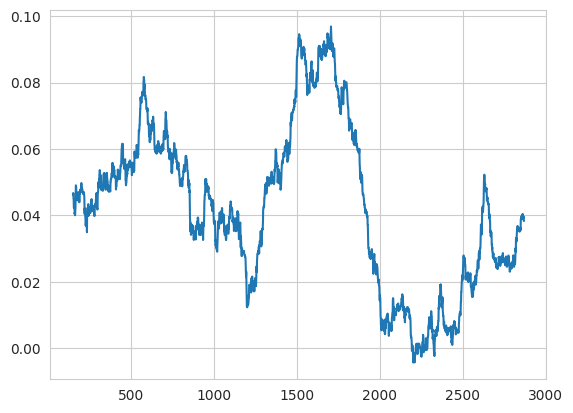

In [ ]:
win_per = 0.1
win_size = int(win_per * textblob_df.shape[0])

_ = textblob_df['sentiment'].rolling(win_size, center=True).mean().plot(grid=True)

In [ ]:
# Save TextBlob Model Sentiment Time Series

save_df2csv_and_download(textblob_df, '_textblob.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: to_the_lighthouse (1)_textblob.csv

STEP 2. Downloading permanent copy of csvfile: to_the_lighthouse (1)_textblob.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**DELETE** SyuzhetR (4)

**DELETE** SentimentR (8)

In [ ]:
# !pip install -q transformers

In [ ]:
# !pip install sentencepiece

In [ ]:
%%time

# NOTE: 1m06s

from transformers import pipeline

from transformers import AutoTokenizer, AutoModelWithLMHead  # T5Base 50k
from transformers import AutoModelForSequenceClassification, Trainer
from transformers import AutoModelForSeq2SeqLM, AutoModelWithLMHead

from transformers import BertTokenizer, BertForSequenceClassification

import sentencepiece

CPU times: user 48 µs, sys: 2 µs, total: 50 µs
Wall time: 53.9 µs


In [ ]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

## Option (2): Transformers: BERT

### HF: Default DistilBERT

distilbert-base-uncased-finetuned-sst-2-english

* https://huggingface.co/docs/transformers/task_summary

In [ ]:
%whos list


Variable                Type    Data/Info
-----------------------------------------
line_ls                 list    n=3019
line_no_ls              list    n=3019
novel_clean_ls          list    n=3019
novel_segments_ls       list    n=3019
sentence_no_ls          list    n=3019
sentiment_textblob_ls   list    n=3019
sentiment_vader_ls      list    n=3019


In [ ]:
line_ls = novel_clean_ls
novel_clean_ls[:20]


['the window 1 "yes, of course, if it\'s fine tomorrow," said mrs. ramsay.',
 '"but you\'ll have to be up with the lark," she added.',
 "to her son these words conveyed an extraordinary joy, as if it were settled, the expedition were bound to take place, and the wonder to which he had looked forward, for years and years it seemed, was, after a night's darkness and a day's sail, within touch.",
 'since he belonged, even at the age of six, to that great clan which cannot keep this feeling separate from that, but must let future prospects, with their joys and sorrows, cloud what is actually at hand, since to such people even in earliest childhood any turn in the wheel of sensation has the power to crystallise and transfix the moment upon which its gloom or radiance rests, james ramsay, sitting on the floor cutting out pictures from the illustrated catalogue of the army and navy stores, endowed the picture of a refrigerator, as his mother spoke, with heavenly bliss.',
 'it was fringed with

In [ ]:
%whos DataFrame

Variable        Type         Data/Info
--------------------------------------
combined_df     DataFrame          vader_sentiment_raw<...>n[3019 rows x 14 columns]
distilbert_df   DataFrame          line_no            <...>\n[3019 rows x 5 columns]
nlptown_df      DataFrame          line_no            <...>\n[3019 rows x 6 columns]
sentiment_df    DataFrame          line_no            <...>\n[3019 rows x 2 columns]
textblob_df     DataFrame          line_no            <...>\n[3019 rows x 3 columns]
vader_df        DataFrame          line_no            <...>\n[3019 rows x 3 columns]


In [ ]:
# Cell 1 – imports, env, dataset, model, trainer

import os
import numpy as np
import pandas as pd

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from torch.utils.data import Dataset

# Disable Weights & Biases explicitly
os.environ["WANDB_DISABLED"] = "true"


# Minimal Dataset wrapper for Trainer.predict
class SimpleDataset(Dataset):
    def __init__(self, tokenized_texts):
        # tokenized_texts should come from tokenizer(..., return_tensors="pt")
        self.input_ids = tokenized_texts["input_ids"]
        self.attention_mask = tokenized_texts["attention_mask"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx].clone().detach(),
            "attention_mask": self.attention_mask[idx].clone().detach(),
        }


# Load tokenizer and model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Trainer config – disable external loggers (wandb, etc.)
training_args = TrainingArguments(
    output_dir="./tmp_results",  # required, even for prediction-only
    report_to="none",           # disable all experiment tracking integrations
)

trainer = Trainer(
    model=model,
    args=training_args,
)


In [ ]:
# Cell 2 – create list of texts and prediction dataset

# Create list of texts (can be imported from .csv, .xls etc.)



# For your actual data, uncomment this and ensure `sentiment_df` exists:
# line_ls = sentiment_df["line"].tolist()

# Tokenize texts and create prediction dataset
tokenized_texts = tokenizer(
    line_ls,
    truncation=True,
    padding=True,
    return_tensors="pt",  # ensures tensors for PyTorch / Trainer
)

pred_dataset = SimpleDataset(tokenized_texts)


In [ ]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Cell 3 – run predictions

%%time
# NOTE: timing info only, adjust or remove as you like

predictions = trainer.predict(pred_dataset)


CPU times: user 22.5 s, sys: 28.3 ms, total: 22.5 s
Wall time: 22.5 s


In [ ]:
# Cell 4 – transform predictions to labels and scores, build DataFrame

def compute_distilbert_sentiment(row):
    """
    Convert binary label + confidence into a signed sentiment:
    POSITIVE  ->  +score
    NEGATIVE  ->  -score

    This yields a continuous sentiment score in approximately [-1, +1],
    where magnitude is confidence and sign is polarity.
    """
    sign = 1 if row["label"] == "POSITIVE" else -1
    return sign * row["score"]

# Optional: inspect prediction output type
type(predictions)

# `predictions.predictions` are the logits
logits = predictions.predictions

# Predicted class indices
sentiment_ls = logits.argmax(-1)

# Map indices to labels using model's config
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)

# Convert logits to probabilities via softmax
probs = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)
scores_ls = probs.max(axis=1)  # confidence score of the predicted class

# Line numbers
line_no_ls = list(range(len(sentiment_ls)))

# Cell – create a signed sentiment score for DistilBERT (range ≈ -1 to +1)




# distilbert_df[["line_no", "label", "score", "distilbert_sentiment"]].head()


# Create DataFrame with texts, predictions, labels, and scores
distilbert_df = pd.DataFrame(
    {
        "line_no": line_no_ls,
        "line": line_ls,
        # "sentiment": sentiment_ls,  # numeric prediction
        "label": labels_ls,         # string label (POSITIVE/NEGATIVE)
        "score": scores_ls,         # confidence score
    }
)

distilbert_df["sentiment"] = distilbert_df.apply(
    compute_distilbert_sentiment, axis=1
)

distilbert_df.head()


transformers.trainer_utils.PredictionOutput

,line_no,line,label,score,sentiment
0,0,"the window 1 ""yes, of course, if it's fine tom...",POSITIVE,0.996124,0.996124
1,1,"""but you'll have to be up with the lark,"" she ...",NEGATIVE,0.974143,-0.974143
2,2,to her son these words conveyed an extraordina...,POSITIVE,0.999797,0.999797
3,3,"since he belonged, even at the age of six, to ...",POSITIVE,0.999387,0.999387
4,4,it was fringed with joy.,POSITIVE,0.999693,0.999693


array(['POSITIVE', 'NEGATIVE'], dtype=object)

Text(0.5, 0, 'Line index')

Text(0, 0.5, 'Rolling mean sentiment')

Text(0.5, 1.0, 'DistilBERT Sentiment (rolling mean)')

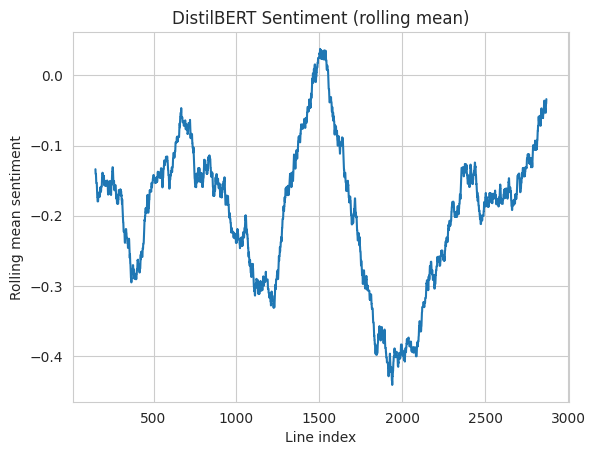

In [ ]:
# Cell 5 – simple exploration & rolling sentiment plot

# Unique labels predicted
distilbert_df["label"].unique()

# Rolling window percentage and size
win_per = 0.1
win_size = max(1, int(win_per * distilbert_df.shape[0]))  # avoid window size 0

# Plot rolling mean of numeric sentiment
ax = distilbert_df["sentiment"].rolling(win_size, center=True).mean().plot(grid=True)
ax.set_xlabel("Line index")
ax.set_ylabel("Rolling mean sentiment")
ax.set_title("DistilBERT Sentiment (rolling mean)")


In [ ]:
# Cell 6 – save model sentiment time series

# Assumes you have defined `save_df2csv_and_download` elsewhere in your notebook.
# Just use the new DataFrame name here.

save_df2csv_and_download(distilbert_df, "_distilbert.csv", nodate=True)


STEP 1. Saving DataFrame to temporary VM file: to_the_lighthouse (1)_distilbert.csv

STEP 2. Downloading permanent copy of csvfile: to_the_lighthouse (1)_distilbert.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>




### HF: MultiBERT NLPTown

nlptown/bert-base-multilingual-uncased-sentiment

* https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=I+like+you.+I+love+you

In [ ]:
###CODE
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
# We do not need to import os or set environment variables anymore

# Load tokenizer and model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# --- KEY MODIFICATION START ---

# 1. Define TrainingArguments with explicit logger configuration
# We must provide an output_dir, even if we are only doing prediction/evaluation.
# The critical step is setting report_to="none" to disable all loggers,
# thereby preventing the automatic initialization of WandB and other loggers.
training_args = TrainingArguments(
    output_dir="./tmp_sentiment_output",  # Required argument for Trainer
    report_to="none",                    # Explicitly disable all loggers/reporters
)

# 2. Initialize Trainer with the configured arguments
trainer = Trainer(
    model=model,
    args=training_args # Pass the configured arguments
)

# --- KEY MODIFICATION END ---

In [ ]:
# Cell 2 – create list of texts and prediction dataset

# For your actual data, uncomment this and ensure `sentiment_df` exists:
# line_ls = sentiment_df["line"].tolist()

# Tokenize texts and create prediction dataset
tokenized_texts = tokenizer(
    line_ls,
    truncation=True,
    padding=True,
    return_tensors="pt",  # ensures tensors for PyTorch / Trainer
)

pred_dataset = SimpleDataset(tokenized_texts)


In [ ]:
# Cell 3 – run predictions

%%time
# NOTE: timing info only, adjust or remove as you like

predictions = trainer.predict(pred_dataset)


CPU times: user 42.9 s, sys: 56.2 ms, total: 43 s
Wall time: 42.9 s


In [ ]:
# Cell 4 – transform predictions to labels and scores, build DataFrame

# Cell – create a star-based sentiment score for NLPTown (range exactly -1 to +1)

def compute_nlptown_sentiment(row):
    """
    Convert 1–5 star label + confidence into a centered, signed sentiment:

    - First, extract the star value from the label (e.g. "4 stars" -> 4).
    - Then map stars to a symmetric scale around 0:
        1 star -> -1
        2 stars -> -0.5
        3 stars -> 0
        4 stars -> +0.5
        5 stars -> +1
      via (stars - 3) / 2.
    - Finally, weight by the model's confidence `score`.

    Result is a continuous sentiment in [-1, +1],
    where magnitude reflects confidence and sign reflects positivity/negativity.
    """
    # Extract integer number of stars from the label string
    # (labels look like "1 star", "2 stars", ..., "5 stars")
    stars = int(str(row["label"]).split()[0])

    # Center around 3 stars and scale to [-1, +1]
    base_sentiment = (stars - 3) / 2.0

    # Weight by the probability of the predicted class
    return base_sentiment * row["score"]

# nlptown_df[["line_no", "label", "score", "nlptown_sentiment"]].head()


# Inspect prediction object type (optional)
type(predictions)

# `predictions.predictions` are the logits
logits = predictions.predictions

# Predicted class indices (0–4 for NLPTown, corresponding to 1–5 stars)
rating_idx = logits.argmax(-1)

# Map indices to textual labels like "1 star", "2 stars", ...
labels_ls = pd.Series(rating_idx).map(model.config.id2label)

# Convert logits to probabilities via softmax
probs = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)
scores_ls = probs.max(axis=1)  # confidence score of the predicted class

# Line numbers
line_no_ls = list(range(len(rating_idx)))

# Create DataFrame with texts, predictions, labels, and scores
# `rating` is the numeric index (0–4), `label` is the human-readable "X star(s)"
nlptown_df = pd.DataFrame(
    {
        "line_no": line_no_ls,
        "line": line_ls,
        "rating": rating_idx,  # numeric prediction (0–4)
        "label": labels_ls,    # string label (e.g., "4 stars")
        "score": scores_ls,    # confidence score
    }
)

nlptown_df["sentiment"] = nlptown_df.apply(
    compute_nlptown_sentiment, axis=1
)

nlptown_df.head()


transformers.trainer_utils.PredictionOutput

,line_no,line,rating,label,score,sentiment
0,0,"the window 1 ""yes, of course, if it's fine tom...",2,3 stars,0.335916,0.000000
1,1,"""but you'll have to be up with the lark,"" she ...",2,3 stars,0.440373,0.000000
2,2,to her son these words conveyed an extraordina...,4,5 stars,0.658196,0.658196
3,3,"since he belonged, even at the age of six, to ...",4,5 stars,0.615873,0.615873
4,4,it was fringed with joy.,4,5 stars,0.534395,0.534395


array(['3 stars', '5 stars', '2 stars', '4 stars', '1 star'], dtype=object)

Text(0.5, 0, 'Line index')

Text(0, 0.5, 'Rolling mean rating (0–4 index)')

Text(0.5, 1.0, 'NLPTown Sentiment (rolling mean rating)')

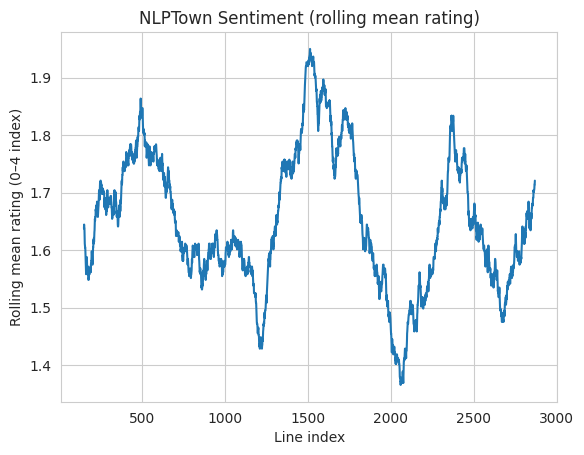

In [ ]:
# Cell 5 – simple exploration & rolling sentiment plot

# Unique labels predicted
nlptown_df["label"].unique()

# Rolling window percentage and size
win_per = 0.1
win_size = max(1, int(win_per * nlptown_df.shape[0]))  # avoid window size 0

# Plot rolling mean of numeric rating (0–4 -> ~1–5 stars)
ax = nlptown_df["rating"].rolling(win_size, center=True).mean().plot(grid=True)
ax.set_xlabel("Line index")
ax.set_ylabel("Rolling mean rating (0–4 index)")
ax.set_title("NLPTown Sentiment (rolling mean rating)")


In [ ]:
# Cell 6 – save model sentiment time series

# Assumes you have defined `save_df2csv_and_download` elsewhere in your notebook.
# Just use the new DataFrame name here.

save_df2csv_and_download(nlptown_df, "_nlptown.csv", nodate=True)


STEP 1. Saving DataFrame to temporary VM file: to_the_lighthouse (1)_nlptown.csv

STEP 2. Downloading permanent copy of csvfile: to_the_lighthouse (1)_nlptown.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot

## Read Time Series

* VADER
* TextBlob
* DistilBERT
* NLPTown

In [ ]:
%whos DataFrame

Variable        Type         Data/Info
--------------------------------------
combined_df     DataFrame          vader_sentiment_raw<...>n[3019 rows x 14 columns]
distilbert_df   DataFrame          line_no            <...>\n[3019 rows x 5 columns]
nlptown_df      DataFrame          line_no            <...>\n[3019 rows x 6 columns]
sentiment_df    DataFrame          line_no            <...>\n[3019 rows x 2 columns]
textblob_df     DataFrame          line_no            <...>\n[3019 rows x 3 columns]
vader_df        DataFrame          line_no            <...>\n[3019 rows x 3 columns]


In [ ]:
vader_df.head()
vader_df.describe()
vader_df.info()
textblob_df.head()
textblob_df.describe()
textblob_df.info()
distilbert_df.head()
distilbert_df.describe()
distilbert_df.info()
nlptown_df.head()
nlptown_df.describe()
nlptown_df.info()

,line_no,line,sentiment
0,0,"the window 1 ""yes, of course, if it's fine tom...",0.5423
1,1,"""but you'll have to be up with the lark,"" she ...",0.0000
2,2,to her son these words conveyed an extraordina...,0.4215
3,3,"since he belonged, even at the age of six, to ...",0.9631
4,4,it was fringed with joy.,0.5859


,line_no,sentiment
count,3019.000000,3019.000000
mean,1509.000000,0.069243
std,871.654557,0.399584
min,0.000000,-0.992200
25%,754.500000,0.000000
50%,1509.000000,0.000000
75%,2263.500000,0.361200
max,3018.000000,0.993400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   line_no    3019 non-null   int64  
 1   line       3019 non-null   object 
 2   sentiment  3019 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 70.9+ KB


,line_no,line,sentiment
0,0,"the window 1 ""yes, of course, if it's fine tom...",0.416667
1,1,"""but you'll have to be up with the lark,"" she ...",0.000000
2,2,to her son these words conveyed an extraordina...,0.566667
3,3,"since he belonged, even at the age of six, to ...",0.011111
4,4,it was fringed with joy.,0.800000


,line_no,sentiment
count,3019.000000,3019.000000
mean,1509.000000,0.042497
std,871.654557,0.244505
min,0.000000,-1.000000
25%,754.500000,0.000000
50%,1509.000000,0.000000
75%,2263.500000,0.100000
max,3018.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   line_no    3019 non-null   int64  
 1   line       3019 non-null   object 
 2   sentiment  3019 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 70.9+ KB


,line_no,line,label,score,sentiment
0,0,"the window 1 ""yes, of course, if it's fine tom...",POSITIVE,0.996124,0.996124
1,1,"""but you'll have to be up with the lark,"" she ...",NEGATIVE,0.974143,-0.974143
2,2,to her son these words conveyed an extraordina...,POSITIVE,0.999797,0.999797
3,3,"since he belonged, even at the age of six, to ...",POSITIVE,0.999387,0.999387
4,4,it was fringed with joy.,POSITIVE,0.999693,0.999693


,line_no,score,sentiment
count,3019.000000,3019.000000,3019.000000
mean,1509.000000,0.954856,-0.181904
std,871.654557,0.094089,0.942234
min,0.000000,0.501257,-0.999809
25%,754.500000,0.968510,-0.995222
50%,1509.000000,0.993224,-0.941178
75%,2263.500000,0.998235,0.986597
max,3018.000000,0.999884,0.999884


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   line_no    3019 non-null   int64  
 1   line       3019 non-null   object 
 2   label      3019 non-null   object 
 3   score      3019 non-null   float32
 4   sentiment  3019 non-null   float64
dtypes: float32(1), float64(1), int64(1), object(2)
memory usage: 106.3+ KB


,line_no,line,rating,label,score,sentiment
0,0,"the window 1 ""yes, of course, if it's fine tom...",2,3 stars,0.335916,0.000000
1,1,"""but you'll have to be up with the lark,"" she ...",2,3 stars,0.440373,0.000000
2,2,to her son these words conveyed an extraordina...,4,5 stars,0.658196,0.658196
3,3,"since he belonged, even at the age of six, to ...",4,5 stars,0.615873,0.615873
4,4,it was fringed with joy.,4,5 stars,0.534395,0.534395


,line_no,rating,score,sentiment
count,3019.000000,3019.000000,3019.000000,3019.000000
mean,1509.000000,1.656840,0.399320,-0.067070
std,871.654557,1.370484,0.118958,0.315858
min,0.000000,0.000000,0.211872,-0.937233
25%,754.500000,1.000000,0.313152,-0.250817
50%,1509.000000,1.000000,0.377223,-0.127560
75%,2263.500000,3.000000,0.456852,0.115933
max,3018.000000,4.000000,0.937233,0.931986


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   line_no    3019 non-null   int64  
 1   line       3019 non-null   object 
 2   rating     3019 non-null   int64  
 3   label      3019 non-null   object 
 4   score      3019 non-null   float32
 5   sentiment  3019 non-null   float64
dtypes: float32(1), float64(1), int64(2), object(2)
memory usage: 129.9+ KB


## Merge Model Data

In [ ]:
import pandas as pd

# Assuming the dataframes are already loaded and have the necessary columns.
# For VADER: 'sentiment'
# For TextBlob: 'sentiment'
# For DistilBERT: 'label', 'score'
# For NLPTown: 'label' (e.g., '1 star' to '5 stars'), 'score'

# Use existing sentiment for VADER
# vader_df['sentiment'] = vader_df['sentiment']

# Use existing sentiment for TextBlob
# textblob_df['sentiment'] = textblob_df['sentiment']


# Since the sentiments are already computed to be within [-1, 1] based on the mappings and scores (<=1),
# no additional normalization is needed.

# Combine into combined_df
combined_df = pd.DataFrame({
    'vader_sentiment': vader_df['sentiment'],
    'textblob_sentiment': textblob_df['sentiment'],
    'distilbert_sentiment': distilbert_df['sentiment'],
    'nlptown_sentiment': nlptown_df['sentiment']
})

# Optional: If there's a common 'text' column, add it
combined_df['line_no'] = vader_df['line_no']  # Uncomment if applicable
combined_df['text'] = vader_df['line']  # Uncomment if applicable
combined_df.head()

,vader_sentiment,textblob_sentiment,distilbert_sentiment,nlptown_sentiment,line_no,text
0,0.5423,0.416667,0.996124,0.000000,0,"the window 1 ""yes, of course, if it's fine tom..."
1,0.0000,0.000000,-0.974143,0.000000,1,"""but you'll have to be up with the lark,"" she ..."
2,0.4215,0.566667,0.999797,0.658196,2,to her son these words conveyed an extraordina...
3,0.9631,0.011111,0.999387,0.615873,3,"since he belonged, even at the age of six, to ..."
4,0.5859,0.800000,0.999693,0.534395,4,it was fringed with joy.


In [ ]:
combined_df.info()
combined_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vader_sentiment       3019 non-null   float64
 1   textblob_sentiment    3019 non-null   float64
 2   distilbert_sentiment  3019 non-null   float64
 3   nlptown_sentiment     3019 non-null   float64
 4   line_no               3019 non-null   int64  
 5   text                  3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 141.6+ KB


,vader_sentiment,textblob_sentiment,distilbert_sentiment,nlptown_sentiment,line_no
count,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000
mean,0.069243,0.042497,-0.181904,-0.067070,1509.000000
std,0.399584,0.244505,0.942234,0.315858,871.654557
min,-0.992200,-1.000000,-0.999809,-0.937233,0.000000
25%,0.000000,0.000000,-0.995222,-0.250817,754.500000
50%,0.000000,0.000000,-0.941178,-0.127560,1509.000000
75%,0.361200,0.100000,0.986597,0.115933,2263.500000
max,0.993400,1.000000,0.999884,0.931986,3018.000000


In [ ]:
def normalize_sentiment_cols(df: pd.DataFrame) -> pd.DataFrame:
    """
    Renames sentiment columns and normalizes them to a [-1.0, 1.0] range.

    1. Finds all columns ending in "_sentiment".
    2. Renames them to have a "_raw" suffix (e.g., "vader_sentiment" -> "vader_sentiment_raw").
    3. Normalizes the values in these "_raw" columns to the full [-1.0, 1.0] range.
    4. Stores the new normalized values in columns with the original names (e.g., "vader_sentiment").

    Args:
        df: The input Pandas DataFrame.

    Returns:
        A new DataFrame with the renamed and normalized columns.
    """
    # Work on a copy to avoid modifying the original DataFrame outside the function
    df_normalized = df.copy()

    # 1. Find all columns ending in "_sentiment" and create a rename map
    sentiment_cols = [col for col in df_normalized.columns if col.endswith('_sentiment')]

    # If no sentiment columns are found, return the original DataFrame copy
    if not sentiment_cols:
        print("No columns ending in '_sentiment' found. Returning original DataFrame.")
        return df_normalized

    rename_map = {col: f"{col}_raw" for col in sentiment_cols}

    # Rename the original columns to have the "_raw" suffix
    df_normalized = df_normalized.rename(columns=rename_map)

    print(f"Step 1: Renamed {len(sentiment_cols)} columns. New raw columns are: {list(rename_map.values())}")

    # 2. Normalize all "_raw" columns to the range [-1.0, 1.0]
    #    and assign to new columns with the original "_sentiment" name.
    for original_name in sentiment_cols:
        raw_name = f"{original_name}_raw"

        # Get the min and max values from the raw data column
        min_val = df_normalized[raw_name].min()
        max_val = df_normalized[raw_name].max()
        val_range = max_val - min_val

        print(f"  Normalizing '{raw_name}' (Range: [{min_val:.6f}, {max_val:.6f}]) -> '{original_name}'")

        # Apply min-max normalization to the range [-1.0, 1.0]
        # Formula: new_val = -1 + ((old_val - min_val) * 2) / (max_val - min_val)
        if val_range == 0:
            # Handle edge case where all values are identical (to avoid division by zero)
            # Map all identical values to 0.0 (the midpoint of the [-1, 1] range)
            df_normalized[original_name] = 0.0
        else:
            df_normalized[original_name] = -1.0 + (((df_normalized[raw_name] - min_val) * 2.0) / val_range)

    return df_normalized

In [ ]:
print("--- Original DataFrame describe() ---")
print(combined_df.describe())
print("\n")

# --- Call the function ---
combined_df = normalize_sentiment_cols(combined_df)

# Display the results
print("\n--- Modified DataFrame describe() ---")
print(combined_df.describe())

print("\n--- Modified DataFrame Head ---")
print(combined_df.head())

# The variable combined_df is now modified as requested.
# === END OF REQUESTED CODE CELL ===

--- Original DataFrame describe() ---
       vader_sentiment  textblob_sentiment  distilbert_sentiment  \
count      3019.000000         3019.000000           3019.000000   
mean          0.069243            0.042497             -0.181904   
std           0.399584            0.244505              0.942234   
min          -0.992200           -1.000000             -0.999809   
25%           0.000000            0.000000             -0.995222   
50%           0.000000            0.000000             -0.941178   
75%           0.361200            0.100000              0.986597   
max           0.993400            1.000000              0.999884   

       nlptown_sentiment      line_no  
count        3019.000000  3019.000000  
mean           -0.067070  1509.000000  
std             0.315858   871.654557  
min            -0.937233     0.000000  
25%            -0.250817   754.500000  
50%            -0.127560  1509.000000  
75%             0.115933  2263.500000  
max             0.931986  301

In [ ]:
combined_df.describe()

,vader_sentiment_raw,textblob_sentiment_raw,distilbert_sentiment_raw,nlptown_sentiment_raw,line_no,vader_sentiment,textblob_sentiment,distilbert_sentiment,nlptown_sentiment
count,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000
mean,0.069243,0.042497,-0.181904,-0.067070,1509.000000,0.069141,0.042497,-0.181970,-0.068956
std,0.399584,0.244505,0.942234,0.315858,871.654557,0.402482,0.244505,0.942379,0.337957
min,-0.992200,-1.000000,-0.999809,-0.937233,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,-0.995222,-0.250817,754.500000,-0.000604,0.000000,-0.995412,-0.265559
50%,0.000000,0.000000,-0.941178,-0.127560,1509.000000,-0.000604,0.000000,-0.941360,-0.133678
75%,0.361200,0.100000,0.986597,0.115933,2263.500000,0.363215,0.100000,0.986711,0.126851
max,0.993400,1.000000,0.999884,0.931986,3018.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
combined_df.head()

,vader_sentiment_raw,textblob_sentiment_raw,distilbert_sentiment_raw,nlptown_sentiment_raw,line_no,text,vader_sentiment,textblob_sentiment,distilbert_sentiment,nlptown_sentiment
0,0.5423,0.416667,0.996124,0.000000,0,"the window 1 ""yes, of course, if it's fine tom...",0.545629,0.416667,0.996240,0.002807
1,0.0000,0.000000,-0.974143,0.000000,1,"""but you'll have to be up with the lark,"" she ...",-0.000604,0.000000,-0.974331,0.002807
2,0.4215,0.566667,0.999797,0.658196,2,to her son these words conveyed an extraordina...,0.423952,0.566667,0.999913,0.707054
3,0.9631,0.011111,0.999387,0.615873,3,"since he belonged, even at the age of six, to ...",0.969480,0.011111,0.999503,0.661770
4,0.5859,0.800000,0.999693,0.534395,4,it was fringed with joy.,0.589545,0.800000,0.999809,0.574591


In [ ]:
# Save Combined Models Sentiment Time Series

save_df2csv_and_download(combined_df, '_combined.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: to_the_lighthouse (1)_combined.csv

STEP 2. Downloading permanent copy of csvfile: to_the_lighthouse (1)_combined.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sentiment_boxplots(df: pd.DataFrame, col_sentiment='all', output_filename: str = 'sentiment_boxplots.png'):
    """
    Plots boxplots for all columns in a DataFrame that end with '_sentiment'.

    Args:
        df: The pandas DataFrame containing the sentiment data.
        output_filename: The name of the file to save the plot.
    """

    if col_sentiment == 'all':
      # Identify columns with "_sentiment" suffix
      sentiment_columns = [col for col in df.columns if col.endswith('_sentiment')]
    else:
      sentiment_columns = [col_sentiment]

    if not sentiment_columns:
        print("Error: No columns with '_sentiment' suffix found in the DataFrame.")
        return

    print(f"Plotting columns: {sentiment_columns}")

    # Create boxplots for these columns
    plt.figure(figsize=(10, 6))

    # Using pandas' boxplot function which relies on matplotlib
    df.boxplot(column=sentiment_columns, grid=False)

    plt.title('Distribution of Sentiment Scores', fontsize=16)
    plt.ylabel('Sentiment Score', fontsize=12)
    plt.xlabel('Sentiment Model', fontsize=12)

    # Clean up x-axis labels (e.g., 'vader_sentiment' -> 'vader')
    clean_labels = [col.replace('_sentiment', '') for col in sentiment_columns]
    plt.xticks(ticks=range(1, len(sentiment_columns) + 1), labels=clean_labels, rotation=0)

    # Ensure the layout is clean
    plt.tight_layout()

    # Save the figure
    plt.savefig(output_filename)
    print(f"Plot saved successfully as '{output_filename}'")



Plotting columns: ['vader_sentiment', 'textblob_sentiment', 'distilbert_sentiment', 'nlptown_sentiment']
Plot saved successfully as 'sentiment_boxplots.png'


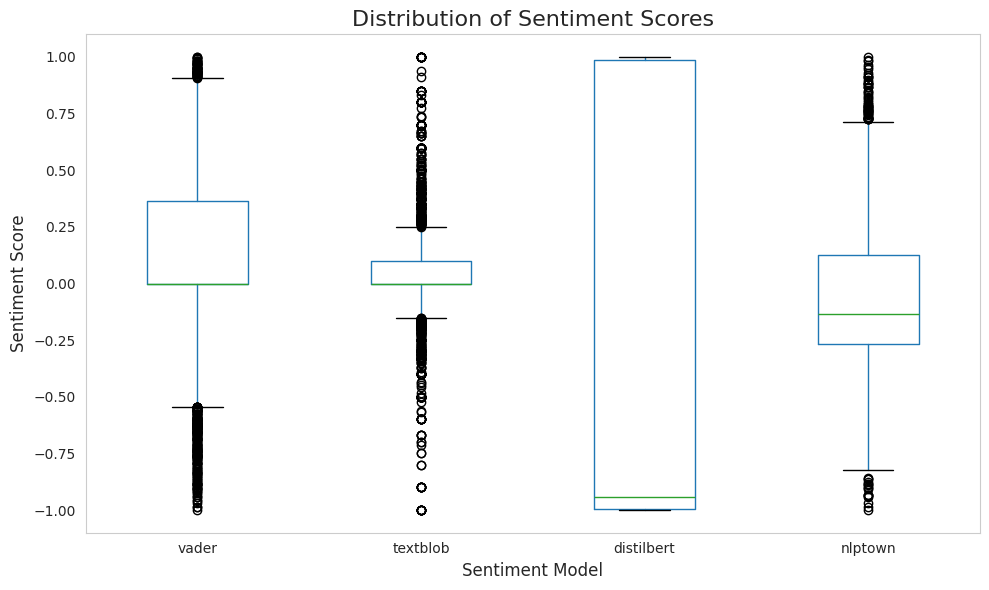

In [ ]:

try:
    # CONFIGURE: set col_sentiment in ['all','vader_sentiment','textblob_sentiment']
    plot_sentiment_boxplots(combined_df, col_sentiment='all')
except NameError:
    print("Note: 'combined_df' is not defined in this environment.")
    print("Please call this function in your environment where 'combined_df' exists.")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Import Seaborn for enhanced statistical plotting

# Configurable parameter for binning/smoothing (though Seaborn handles this adaptively)
SENTIMENT_BIN = 0.1

def plot_sentiment_kde(df: pd.DataFrame, SENTIMENT_BIN: float = 0.1, output_filename: str = 'sentiment_kde_plots.png'):
    """
    Plots smoothed Kernel Density Estimate (KDE) distributions for all sentiment
    columns in a DataFrame. This visualization shows the underlying shape of the
    distribution (modality, skewness) more clearly than boxplots.

    Args:
        df: The pandas DataFrame containing the sentiment data.
        SENTIMENT_BIN: A placeholder for binning control. KDE plots smooth the data
                       adaptively, but this is kept to honor the original request
                       while leveraging Seaborn's superior smoothing capabilities.
        output_filename: The name of the file to save the plot.
    """

    # Identify columns with "_sentiment" suffix
    sentiment_columns = [col for col in df.columns if col.endswith('_sentiment')]

    if not sentiment_columns:
        print("Error: No columns with '_sentiment' suffix found in the DataFrame.")
        return

    print(f"Plotting KDE for columns: {sentiment_columns}")
    print(f"Using a nominal bin size of: {SENTIMENT_BIN}")

    # Set up the plot for multiple overlaid distributions
    plt.figure(figsize=(12, 7))

    # Optional: Set a clean style for Seaborn plots
    sns.set_style("whitegrid")

    # Iterate through each sentiment column and plot the KDE
    for col in sentiment_columns:
        # Use Seaborn's kdeplot. The 'label' parameter helps in the legend.
        # The 'bw_adjust' parameter can be used to manually control smoothing,
        # but the default often works well.
        sns.kdeplot(
            data=df[col].dropna(), # Drop NaNs to ensure robustness
            label=col.replace('_sentiment', ''),
            linewidth=2.5,
            fill=True,
            alpha=0.2 # Transparency for the filled area
        )

    # Set plot aesthetics
    plt.title('Smoothed Distribution of Sentiment Scores (KDE)', fontsize=18)
    plt.xlabel(f'Sentiment Score (Normalized [-1.0 to 1.0])', fontsize=14)
    plt.ylabel('Density (Smoothed Count)', fontsize=14)

    # Add a legend to distinguish the models
    plt.legend(title='Sentiment Model', fontsize=12)

    # Set the x-axis limits to the standard sentiment range
    plt.xlim(-1.05, 1.05)

    # Ensure the layout is clean
    plt.tight_layout()

    # Save the figure
    plt.savefig(output_filename)
    print(f"Plot saved successfully as '{output_filename}'")

    # Reset to default style after plotting if desired
    # sns.set_style("darkgrid")

Plotting KDE for columns: ['vader_sentiment', 'textblob_sentiment', 'distilbert_sentiment', 'nlptown_sentiment']
Using a nominal bin size of: 0.1
Plot saved successfully as 'sentiment_kde_plots.png'


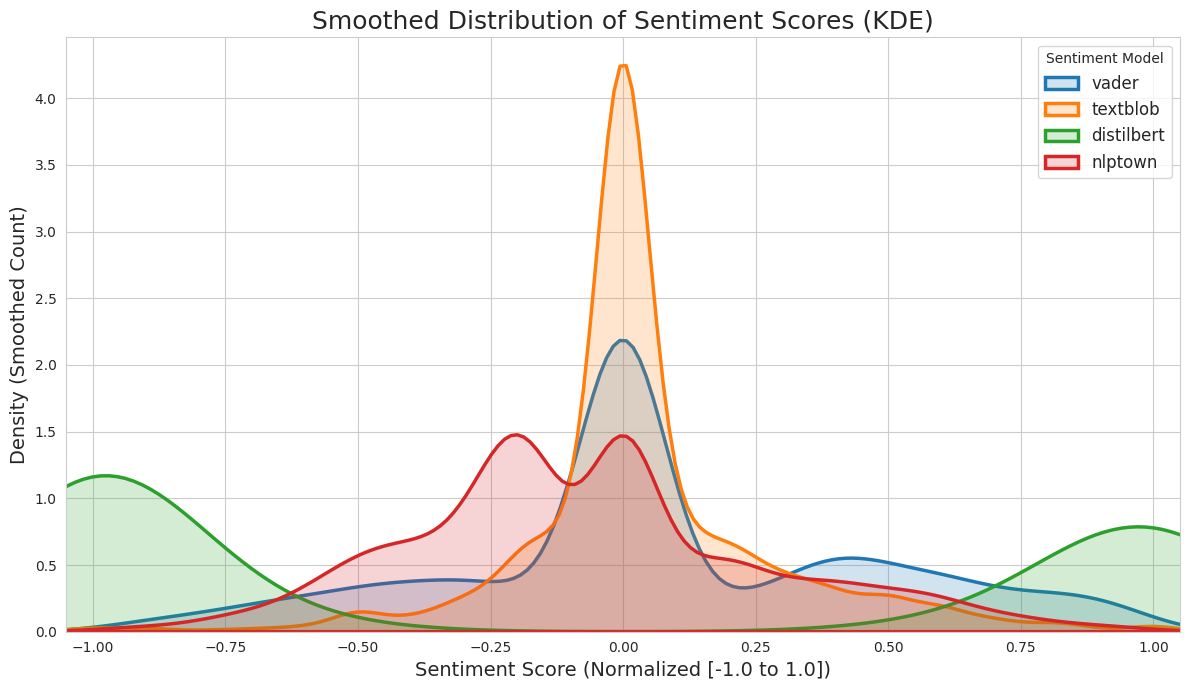

In [ ]:
# EXECUTION CELL
# This calls the plotting function defined above.

# Ensure the required libraries are imported if not already in the environment
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Ensure this is available

try:
    # Set the configurable parameter for bin size
    SENTIMENT_BIN = 0.1

    # Call the new plotting function
    plot_sentiment_kde(combined_df, SENTIMENT_BIN=SENTIMENT_BIN)

except NameError:
    print("\nNote: 'combined_df' is not defined in this environment.")
    print("Please call this function in your environment where 'combined_df' exists.")
except Exception as e:
    print(f"\nAn error occurred during plotting: {e}")

## Plot Unsmoothed Raw Time Series

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_diachronic_sentiment(df: pd.DataFrame, col_sentiment='all', output_filename: str = 'diachronic_sentiment_plot.png'):
    """
    Plots a diachronic sentiment analysis (sentiment over text progression).

    It uses 'line_no' as the x-axis and plots a separate line for each
    column ending in '_sentiment'.

    Args:
        df: The pandas DataFrame. Must contain 'line_no' and sentiment columns.
        output_filename: The name of the file to save the plot.
    """

    if col_sentiment == 'all':
      # Identify columns with "_sentiment" suffix
      sentiment_columns = [col for col in df.columns if col.endswith('_sentiment')]
    else:
      sentiment_columns = [col_sentiment]

    if not sentiment_columns:
        print("Error: No columns with '_sentiment' suffix found in the DataFrame.")
        return


    if 'line_no' not in df.columns:
        print("Error: 'line_no' column not found. This is required for the x-axis.")
        return

    if not sentiment_columns:
        print("Error: No columns with '_sentiment' suffix found in the DataFrame.")
        return

    print(f"Plotting columns: {sentiment_columns}")

    # Ensure data is sorted by line number for a correct line plot
    df_sorted = df.sort_values(by='line_no')

    # Create the plot
    plt.figure(figsize=(15, 7)) # A wider figure is better for line plots

    for col in sentiment_columns:
        # Get a clean label for the legend (e.g., 'vader')
        label_name = col.replace('_sentiment', '')

        # Plot line_no vs. the sentiment score
        plt.plot(df_sorted['line_no'], df_sorted[col], label=label_name, alpha=0.8)

    plt.title('Diachronic Sentiment Analysis', fontsize=16)
    plt.xlabel('Line Number (Progression of Text)', fontsize=12)
    plt.ylabel('Sentiment Score', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Add a horizontal line at y=0 (neutral sentiment) for reference
    plt.axhline(0, color='black', linestyle='--', linewidth=0.75, label='Neutral (0.0)')

    plt.tight_layout()

    # Save the figure
    plt.savefig(output_filename)
    print(f"Diachronic plot saved successfully as '{output_filename}'")



Plotting columns: ['vader_sentiment', 'textblob_sentiment', 'distilbert_sentiment', 'nlptown_sentiment']
Diachronic plot saved successfully as 'diachronic_sentiment_plot.png'


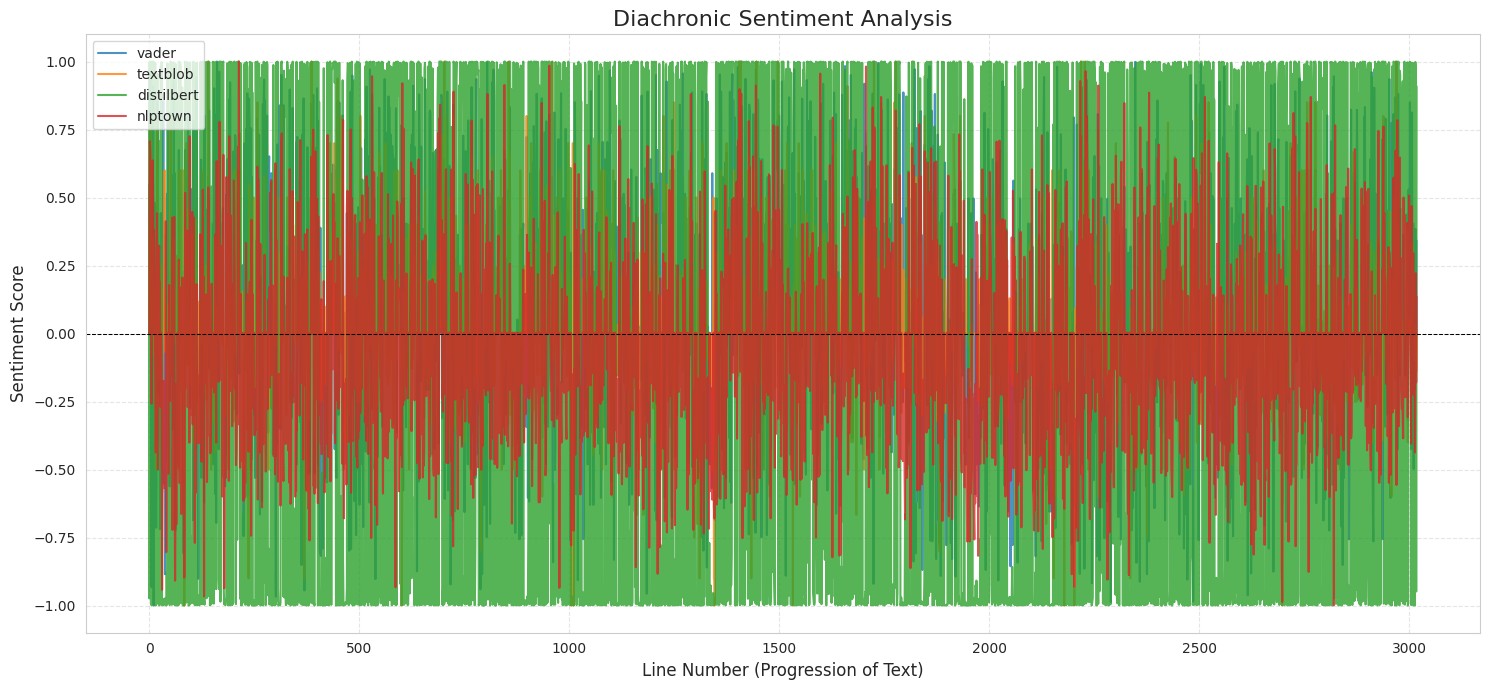

In [ ]:

try:
    # CONFIGURE: set col_sentiment in ['all','vader_sentiment','textblob_sentiment']
    plot_diachronic_sentiment(combined_df, col_sentiment='all')
except NameError:
    print("Note: 'combined_df' is not defined in this environment.")
    print("Please call this function in your environment where 'combined_df' exists.")


# STEP #1: Imports, helper, and single plotting function

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.signal import savgol_filter
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False
    print("Warning: 'scipy' module not found. Savitzky-Golay ('s-g') smoothing will not be available.")


def apply_ewm_manual(series: pd.Series, span: int, start_value: float = 0.0) -> pd.Series:
    """
    Manually implements an exponential weighted moving average (EWM)
    with a custom starting value (e.g., 0.0 for neutral sentiment).
    """
    alpha = 2.0 / (span + 1.0)

    x_data = series.values
    if len(x_data) == 0:
        return series.copy()

    # store as float to avoid integer truncation
    y_smooth = np.zeros_like(x_data, dtype=float)

    # first value
    y_smooth[0] = (alpha * x_data[0]) + (1 - alpha) * start_value

    for i in range(1, len(x_data)):
        y_smooth[i] = (alpha * x_data[i]) + (1 - alpha) * y_smooth[i - 1]

    return pd.Series(y_smooth, index=series.index, name=series.name)


def plot_diachronic_sentiment(
    df: pd.DataFrame,
    smoothing_method: str | None = "sma",
    col_sentiment: str = "all",
    output_filename: str = "diachronic_sentiment_plot.png",
    **kwargs,
) -> pd.DataFrame:
    """
    Plot diachronic sentiment with optional smoothing AND
    (for smoothed methods) write new columns into df.

    Parameters
    ----------
    df : DataFrame
        Must contain 'line_no' and one or more '*_sentiment' columns.
    smoothing_method : {'sma','es','s-g',None,'raw'}
        Smoothing algorithm. None/'raw' => no smoothing.
    col_sentiment : {'all', '<column_name>'}
        'all' => use all '*_sentiment' columns.
        otherwise, the specific sentiment column to plot/smooth.
    output_filename : str
        File name for the saved figure.
    **kwargs :
        For 'sma': window_size (int)
        For 'es' : span (int)
        For 's-g': window_length (int), polyorder (int)
    """

    if df is None:
        print("Error: The DataFrame passed to the function is None.")
        return pd.DataFrame()

    if "line_no" not in df.columns:
        print("Error: 'line_no' column not found. This is required for the x-axis.")
        return df

    # --- choose which sentiment columns to use ---
    all_sentiment_cols = [c for c in df.columns if c.endswith("_sentiment")]
    if not all_sentiment_cols:
        print("Error: No columns with '_sentiment' suffix found in the DataFrame.")
        return df

    if col_sentiment == "all":
        sentiment_columns = all_sentiment_cols
    else:
        if col_sentiment not in df.columns:
            print(f"Error: Selected col_sentiment '{col_sentiment}' not in DataFrame.")
            return df
        sentiment_columns = [col_sentiment]

    # normalise smoothing method
    if smoothing_method:
        smoothing_method = smoothing_method.lower().strip()

    title_suffix = ""
    plot_suffix = None  # suffix for new smoothed columns

    if smoothing_method == "sma":
        window_size = kwargs.get("window_size", 50)
        title_suffix = f" (SMA, window={window_size})"
        plot_suffix = "_sma"
        print(f"Applying SMA smoothing (window={window_size}) and saving to '{plot_suffix}' columns.")

    elif smoothing_method == "es":
        span = kwargs.get("span", 50)
        title_suffix = f" (Manual ES, span={span}, start=0.0)"
        plot_suffix = "_es"
        print(f"Applying Manual ES (span={span}, start_val=0.0) and saving to '{plot_suffix}' columns.")

    elif smoothing_method == "s-g":
        if not SCIPY_AVAILABLE:
            print("Error: Savitzky-Golay requires 'scipy'. Cannot proceed with 's-g'.")
            return df

        window_length = kwargs.get("window_length", 51)
        polyorder = kwargs.get("polyorder", 2)

        if window_length % 2 == 0:
            window_length += 1
            print(f"Warning: S-G window_length must be odd. Using {window_length}.")
        if window_length <= polyorder:
            polyorder = max(1, window_length - 2)
            print(f"Warning: S-G polyorder must be < window_length. Using {polyorder}.")

        title_suffix = f" (Savitzky-Golay, w={window_length}, p={polyorder})"
        plot_suffix = "_s-g"
        print(f"Applying S-G (w={window_length}, p={polyorder}) and saving to '{plot_suffix}' columns.")

    elif smoothing_method is None or smoothing_method == "raw":
        title_suffix = " (Raw Data)"
        print("Plotting raw data only; no new smoothed columns will be added.")

    else:
        print(f"Error: Unknown smoothing_method '{smoothing_method}'.")
        print("Valid options are 'sma', 'es', 's-g', or None/'raw'.")
        return df

    # --- Plotting and calculation ---
    df_sorted = df.sort_values(by="line_no")
    plt.figure(figsize=(15, 7))

    for col in sentiment_columns:
        label_name = col.replace("_sentiment", "")
        y_data = df_sorted[col]
        x_data = df_sorted["line_no"]

        if smoothing_method == "sma":
            y_smooth = y_data.rolling(window=window_size, center=True, min_periods=1).mean()
        elif smoothing_method == "es":
            y_smooth = apply_ewm_manual(y_data, span, start_value=0.0)
        elif smoothing_method == "s-g":
            y_smooth_array = savgol_filter(y_data, window_length, polyorder)
            y_smooth = pd.Series(y_smooth_array, index=y_data.index, name=col)
        else:  # None/raw
            y_smooth = y_data

        plt.plot(x_data, y_smooth, label=label_name, alpha=0.8)

        # write smoothed series back to the original df if we have a suffix
        if smoothing_method not in (None, "raw") and plot_suffix is not None:
            new_col_name = f"{col}{plot_suffix}"
            # align by index, in case df_sorted is a re-ordered view
            df.loc[y_smooth.index, new_col_name] = y_smooth

    plt.title(f"Diachronic Sentiment Analysis{title_suffix}", fontsize=16)
    plt.xlabel("Line Number (Progression of Text)", fontsize=12)
    plt.ylabel("Sentiment Score", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.axhline(0, color="black", linestyle="--", linewidth=0.75)

    plt.tight_layout()
    plt.savefig(output_filename)
    print(f"Plot saved successfully as '{output_filename}'")

    return df


# STEP #2: Choose smoothing method + sentiment selection, set params ONCE, then plot ONCE

In [ ]:
# CONFIGURE #1: Configure models/params for EMSEMBLE PLOT (CODE_PLOT_CONFIG)

# Central configuration for diachronic sentiment plotting

# Used only for filename; does not affect calculations
novel_title_author = "to-the-lighthouse_virginia_woolf"

# (a) Choose smoothing method: 'sma', 'es', 's-g', or 'raw'
smoothing_method = "sma"   # change to 'es', 's-g', or 'raw' as desired

# (b) Choose which sentiment columns to plot:
#   'all'                  -> all '*_sentiment' columns
#   'vader_sentiment'      -> just that column
#   'textblob_sentiment'   -> just that column
#   'distilbert_sentiment' -> etc.
#   'nlptown_sentiment'    -> etc.
col_sentiment = "all"

# (c) Smoothing parameters (intuitive, centralized)
# These are percentages of the text length, not absolute window sizes.
# They will be converted to actual window/span sizes later.

# For Simple Moving Average (SMA)
window_percent_sma = 10  # e.g., 10% of the text length

# For Exponential Smoothing (ES, manual EWM)
span_percent_es = 5      # e.g., 5% of the text length

# For Savitzky–Golay (S-G)
window_percent_sg = 10   # e.g., 10% of the text length
polyorder_sg = 2         # polynomial order (typical values: 2 or 3)


In [ ]:
###CODE_PLOT_1:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.signal import savgol_filter
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False
    print("Warning: 'scipy' module not found. Savitzky-Golay ('s-g') smoothing will not be available.")


def apply_ewm_manual(series: pd.Series, span: int, start_value: float = 0.0) -> pd.Series:
    """
    Manually implements an exponential weighted moving average (EWM)
    with a custom starting value (e.g., 0.0 for neutral sentiment).
    """
    alpha = 2.0 / (span + 1.0)

    x_data = series.values
    if len(x_data) == 0:
        return series.copy()

    # store as float to avoid integer truncation
    y_smooth = np.zeros_like(x_data, dtype=float)

    # first value
    y_smooth[0] = (alpha * x_data[0]) + (1 - alpha) * start_value

    for i in range(1, len(x_data)):
        y_smooth[i] = (alpha * x_data[i]) + (1 - alpha) * y_smooth[i - 1]

    return pd.Series(y_smooth, index=series.index, name=series.name)


def normalize_series_to_minus1_1(series: pd.Series) -> pd.Series:
    """
    Normalize a 1D numeric series to the range [-1.0, 1.0] using min-max scaling.

    If all values are identical, returns a series of 0.0 (the midpoint).
    """
    vals = series.values.astype(float)
    min_val = np.nanmin(vals)
    max_val = np.nanmax(vals)
    val_range = max_val - min_val

    if not np.isfinite(min_val) or not np.isfinite(max_val):
        # fallback if data are weird; just return zeros
        return pd.Series(0.0, index=series.index, name=series.name)

    if val_range == 0:
        # all values identical -> map to 0.0
        return pd.Series(0.0, index=series.index, name=series.name)

    # scale to [-1, 1]
    scaled = -1.0 + ((vals - min_val) * 2.0) / val_range
    return pd.Series(scaled, index=series.index, name=series.name)


def plot_diachronic_sentiment(
    df: pd.DataFrame,
    smoothing_method: str | None = "sma",
    col_sentiment: str = "all",
    output_filename: str = "diachronic_sentiment_plot.png",
    **kwargs,
) -> pd.DataFrame:
    """
    Plot diachronic sentiment with optional smoothing.

    IMPORTANT:
      - For any chosen method (including 'raw'), the series that are actually
        plotted are FIRST smoothed (if applicable) and THEN normalized to the
        full [-1.0, 1.0] range.
      - For smoothed methods ('sma', 'es', 's-g'), we also write the *normalized*
        smoothed series back into the DataFrame as new columns:
            <original_col_name> + <plot_suffix>
        e.g., "vader_sentiment_sma", "textblob_sentiment_es", etc.

    Parameters
    ----------
    df : DataFrame
        Must contain 'line_no' and one or more '*_sentiment' columns.
    smoothing_method : {'sma','es','s-g',None,'raw'}
        Smoothing algorithm. None/'raw' => no smoothing, but still normalized.
    col_sentiment : {'all', '<column_name>'}
        'all' => use all '*_sentiment' columns.
        otherwise, the specific sentiment column to plot/smooth.
    output_filename : str
        File name for the saved figure.
    **kwargs :
        For 'sma': window_size (int)
        For 'es' : span (int)
        For 's-g': window_length (int), polyorder (int)

    Returns
    -------
    df : DataFrame
        Original DataFrame with extra normalized smoothed columns (for
        smoothed methods).
    """

    if df is None:
        print("Error: The DataFrame passed to the function is None.")
        return pd.DataFrame()

    if "line_no" not in df.columns:
        print("Error: 'line_no' column not found. This is required for the x-axis.")
        return df

    # --- choose which sentiment columns to use ---
    all_sentiment_cols = [c for c in df.columns if c.endswith("_sentiment")]
    if not all_sentiment_cols:
        print("Error: No columns with '_sentiment' suffix found in the DataFrame.")
        return df

    if col_sentiment == "all":
        sentiment_columns = all_sentiment_cols
    else:
        if col_sentiment not in df.columns:
            print(f"Error: Selected col_sentiment '{col_sentiment}' not in DataFrame.")
            return df
        sentiment_columns = [col_sentiment]

    # normalize smoothing method string
    if smoothing_method:
        smoothing_method = smoothing_method.lower().strip()

    title_suffix = ""
    plot_suffix = None  # suffix for new smoothed columns

    if smoothing_method == "sma":
        window_size = kwargs.get("window_size", 50)
        title_suffix = f" (SMA + normalization, window={window_size})"
        plot_suffix = "_sma"
        print(f"Applying SMA smoothing (window={window_size}), then normalizing to [-1, 1].")

    elif smoothing_method == "es":
        span = kwargs.get("span", 50)
        title_suffix = f" (Manual ES + normalization, span={span}, start=0.0)"
        plot_suffix = "_es"
        print(f"Applying Manual ES (span={span}, start_val=0.0), then normalizing to [-1, 1].")

    elif smoothing_method == "s-g":
        if not SCIPY_AVAILABLE:
            print("Error: Savitzky-Golay requires 'scipy'. Cannot proceed with 's-g'.")
            return df

        window_length = kwargs.get("window_length", 51)
        polyorder = kwargs.get("polyorder", 2)

        if window_length % 2 == 0:
            window_length += 1
            print(f"Warning: S-G window_length must be odd. Using {window_length}.")
        if window_length <= polyorder:
            polyorder = max(1, window_length - 2)
            print(f"Warning: S-G polyorder must be < window_length. Using {polyorder}.")

        title_suffix = f" (Savitzky-Golay + normalization, w={window_length}, p={polyorder})"
        plot_suffix = "_s-g"
        print(f"Applying S-G (w={window_length}, p={polyorder}), then normalizing to [-1, 1].")

    elif smoothing_method is None or smoothing_method == "raw":
        title_suffix = " (Raw data + normalization)"
        print("No smoothing; directly normalizing each sentiment series to [-1, 1].")

    else:
        print(f"Error: Unknown smoothing_method '{smoothing_method}'.")
        print("Valid options are 'sma', 'es', 's-g', or None/'raw'.")
        return df

    # --- Plotting and calculation ---
    df_sorted = df.sort_values(by="line_no")
    plt.figure(figsize=(15, 7))

    for col in sentiment_columns:
        label_name = col.replace("_sentiment", "")
        y_data = df_sorted[col].astype(float)
        x_data = df_sorted["line_no"]

        # 1) Smooth (if needed)
        if smoothing_method == "sma":
            window_size = kwargs.get("window_size", 50)
            y_processed = y_data.rolling(
                window=window_size,
                center=True,
                min_periods=1
            ).mean()

        elif smoothing_method == "es":
            span = kwargs.get("span", 50)
            y_processed = apply_ewm_manual(y_data, span, start_value=0.0)

        elif smoothing_method == "s-g":
            window_length = kwargs.get("window_length", 51)
            polyorder = kwargs.get("polyorder", 2)
            y_smooth_array = savgol_filter(y_data, window_length, polyorder)
            y_processed = pd.Series(y_smooth_array, index=y_data.index, name=col)

        else:  # None/raw
            y_processed = y_data

        # 2) Normalize the (possibly smoothed) series to [-1.0, 1.0]
        y_normalized = normalize_series_to_minus1_1(y_processed)

        # 3) Plot normalized series
        plt.plot(x_data, y_normalized, label=label_name, alpha=0.8)

        # 4) Write normalized smoothed series back into the original df if we have a suffix
        #    (for 'raw', no new columns are added)
        if smoothing_method not in (None, "raw") and plot_suffix is not None:
            new_col_name = f"{col}{plot_suffix}"
            # align by index, in case df_sorted is a re-ordered view
            df.loc[y_normalized.index, new_col_name] = y_normalized

    plt.title(f"Diachronic Sentiment Analysis{title_suffix}", fontsize=16)
    plt.xlabel("Line Number (Progression of Text)", fontsize=12)
    plt.ylabel("Normalized Sentiment Score [-1, 1]", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.axhline(0, color="black", linestyle="--", linewidth=0.75)

    plt.tight_layout()
    plt.savefig(output_filename)
    print(f"Plot saved successfully as '{output_filename}'")

    return df


Smoothing method : sma
Sentiment column : all
Extra parameters : {'window_size': 301}
Output filename  : novel_to_the_lighthouse (1)_sma-10_all_sentimentarcs.png
Applying SMA smoothing (window=301), then normalizing to [-1, 1].
Plot saved successfully as 'novel_to_the_lighthouse (1)_sma-10_all_sentimentarcs.png'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   vader_sentiment_raw       3019 non-null   float64
 1   textblob_sentiment_raw    3019 non-null   float64
 2   distilbert_sentiment_raw  3019 non-null   float64
 3   nlptown_sentiment_raw     3019 non-null   float64
 4   line_no                   3019 non-null   int64  
 5   text                      3019 non-null   object 
 6   vader_sentiment           3019 non-null   float64
 7   textblob_sentiment        3019 non-null   float64
 8   distilbert_sentiment    

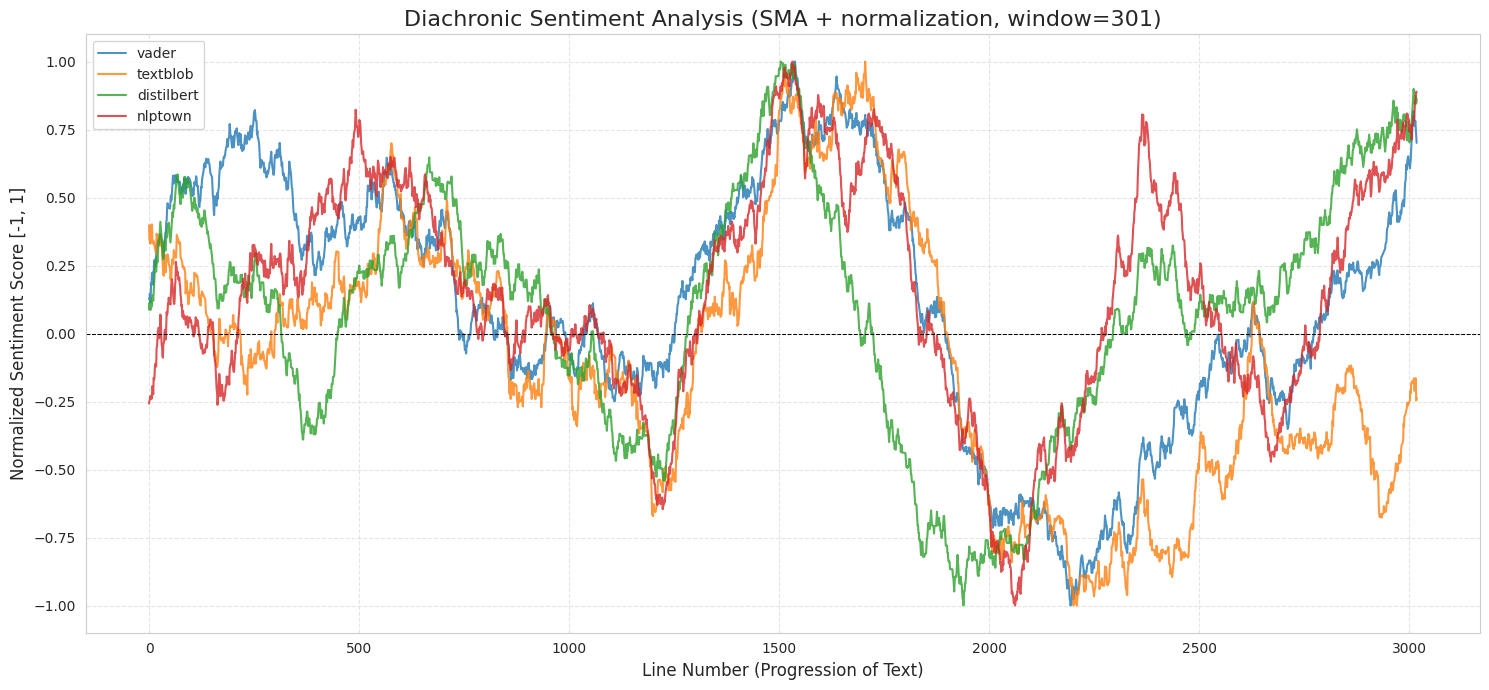

In [ ]:
# Use the config above + the plotting function to build and plot
# NOTE: Assumes `combined_df` already exists and contains 'line_no'
#       plus at least one '*_sentiment' column.

# Fix: Define 'novel_title_author' as it was not found in the current execution environment.
# We'll derive it from the 'novel_name_str' that was uploaded.
# If a specific title (like "The Great Gatsby" as seen in another cell) is desired,
# it should be explicitly set here or ensure the relevant configuration cell is run.
if 'novel_name_str' in globals() and novel_name_str:
    novel_title_author = novel_name_str.split('.')[0] # e.g., "to_the_lighthouse"
else:
    novel_title_author = "unknown_novel" # Fallback if novel_name_str is not available

# --- Derive method-specific parameters once based on config and text length ---
n_lines = len(combined_df)

smoothing_kwargs = {}

if smoothing_method == "sma":
    # window size as a percentage of text length
    window_size = max(3, int(n_lines * (window_percent_sma / 100.0)))
    smoothing_kwargs["window_size"] = window_size
    suffix_for_filename = f"sma-{window_percent_sma}"

elif smoothing_method == "es":
    span_size = max(3, int(n_lines * (span_percent_es / 100.0)))
    smoothing_kwargs["span"] = span_size
    suffix_for_filename = f"es-{span_percent_es}"

elif smoothing_method == "s-g":
    window_length = max(5, int(n_lines * (window_percent_sg / 100.0)))
    if window_length % 2 == 0:
        window_length += 1  # must be odd
    smoothing_kwargs["window_length"] = window_length
    smoothing_kwargs["polyorder"] = polyorder_sg
    suffix_for_filename = f"s-g-{window_percent_sg}"

else:  # 'raw' / None
    smoothing_method = None
    suffix_for_filename = "raw"

output_filename = f"novel_{novel_title_author}_{suffix_for_filename}_{col_sentiment}_sentimentarcs.png"

print(f"Smoothing method : {smoothing_method}")
print(f"Sentiment column : {col_sentiment}")
print(f"Extra parameters : {smoothing_kwargs}")
print(f"Output filename  : {output_filename}")

# --- Single call to the plotting function (with normalization built-in) ---
combined_df = plot_diachronic_sentiment(
    combined_df,
    smoothing_method=smoothing_method,
    col_sentiment=col_sentiment,
    output_filename=output_filename,
    **smoothing_kwargs,
)

# (Optional) inspect new columns (note: smoothed columns are already normalized to [-1, 1])
combined_df.info()


# EXTRACT CRUX POINTS:

## STEP #1: Crux detection configuration (model, smoothing, params, window)

In [ ]:
# EXTRACT CRUX POINTS:

## STEP #1: Crux detection configuration (model, smoothing, params, window)

# Cell 1 – Crux detection configuration (model(s), smoothing, params, window)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy.signal import savgol_filter, find_peaks
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False
    print("Warning: 'scipy' module not found.")
    print("  - Savitzky-Golay smoothing ('s-g') and peak detection require scipy.signal.")


In [ ]:
# CONFIGURE #2: Choose model/params for CRUX PLOT

# ---------------------------------------------------------------------
# 0. Novel identifier (used for plot titles and filenames)
# ---------------------------------------------------------------------
novel_title_author = "The Great Gatsby"

# ---------------------------------------------------------------------
# 1. CONFIGURE: Which sentiment model(s) to use for crux detection
#    Choices: 'vader', 'textblob', 'distilbert', 'nlptown', 'all'
#    - 'all' = average of all *available* sentiment models.
# ---------------------------------------------------------------------
crux_model_choice = "distilbert"  # <- change here

# mapping from friendly model key to sentiment column name in combined_df
MODEL_TO_COL = {
    "vader": "vader_sentiment",
    "textblob": "textblob_sentiment",
    "distilbert": "distilbert_sentiment",
    "nlptown": "nlptown_sentiment",
}

# ---------------------------------------------------------------------
# 2. CONFIGURE: Smoothing method (for the aggregate arc)
#    Choices: 'sma' (simple moving average),
#             'es'  (exponential smoothing),
#             's-g' (Savitzky–Golay)
# ---------------------------------------------------------------------
crux_smoothing_method = "s-g"  # <- change here: 'sma', 'es', or 's-g'

# ---------------------------------------------------------------------
# 3. CONFIGURE: Smoothing hyperparameters (as % of text length)
#     - For 'sma' : window_percent_sma
#     - For 'es'  : span_percent_es
#     - For 's-g' : window_percent_sg + polyorder_sg
# ---------------------------------------------------------------------
window_percent_sma = 10  # SMA: moving window = 10% of text length
span_percent_es   = 5    # ES : span          = 5% of text length
window_percent_sg = 10   # S-G: window length = 10% of text length
polyorder_sg      = 2    # S-G: polynomial order

# ---------------------------------------------------------------------
# 4. CONFIGURE: Peak / valley detection parameters
# ---------------------------------------------------------------------
PEAK_DISTANCE   = 75      # min horizontal distance (in lines) between extrema
PEAK_PROMINENCE = 0.05    # min vertical prominence of extrema (in normalized units)

# ---------------------------------------------------------------------
# 5. CONFIGURE: Crux extraction window
#     CRUX_WINDOW_HALF = number of lines on each side of crux line.
#     Total window = 2 * CRUX_WINDOW_HALF + 1.
# ---------------------------------------------------------------------
CRUX_WINDOW_HALF = 5

In [ ]:
# ---------------------------------------------------------------------
# 6. Derive concrete smoothing parameters from percentages
# ---------------------------------------------------------------------
n_lines = len(combined_df)

crux_smoothing_kwargs = {}
method_for_label = crux_smoothing_method  # keep original string for titles
crux_smoothing_param_str = ""

if crux_smoothing_method == "sma":
    window_size = max(3, int(n_lines * (window_percent_sma / 100.0)))
    crux_smoothing_kwargs["window_size"] = window_size
    crux_smoothing_param_str = f"window={window_size}"

elif crux_smoothing_method == "es":
    span_size = max(3, int(n_lines * (span_percent_es / 100.0)))
    crux_smoothing_kwargs["span"] = span_size
    crux_smoothing_param_str = f"span={span_size}"

elif crux_smoothing_method == "s-g":
    window_length = max(5, int(n_lines * (window_percent_sg / 100.0)))
    if window_length % 2 == 0:
        window_length += 1  # must be odd
    crux_smoothing_kwargs["window_length"] = window_length
    crux_smoothing_kwargs["polyorder"] = polyorder_sg
    crux_smoothing_param_str = f"w={window_length}, p={polyorder_sg}"

else:
    raise ValueError(
        f"Unknown crux_smoothing_method '{crux_smoothing_method}'. "
        "Valid options: 'sma', 'es', 's-g'."
    )

# ---------------------------------------------------------------------
# 7. Human-readable model label for plotting / filenames
# ---------------------------------------------------------------------
if crux_model_choice == "all":
    model_label_short = "allmodels"
    model_label_pretty = "vader + textblob + distilbert + nlptown (average)"
else:
    if crux_model_choice not in MODEL_TO_COL:
        raise ValueError(
            f"Unknown crux_model_choice '{crux_model_choice}'. "
            "Valid options: 'vader', 'textblob', 'distilbert', 'nlptown', 'all'."
        )
    model_label_short = crux_model_choice
    model_label_pretty = crux_model_choice

print("\nCrux detection configuration:")
print(f"  Novel              : {novel_title_author}")
print(f"  Sentiment model(s) : {crux_model_choice} -> {model_label_pretty}")
print(f"  Smoothing method   : {crux_smoothing_method}")
print(f"  Smoothing params   : {crux_smoothing_param_str}")
print(f"  Peak distance      : {PEAK_DISTANCE}")
print(f"  Peak prominence    : {PEAK_PROMINENCE}")
print(f"  CRUX_WINDOW_HALF   : {CRUX_WINDOW_HALF}")



Crux detection configuration:
  Novel              : The Great Gatsby
  Sentiment model(s) : distilbert -> distilbert
  Smoothing method   : s-g
  Smoothing params   : w=301, p=2
  Peak distance      : 75
  Peak prominence    : 0.05
  CRUX_WINDOW_HALF   : 5



--- Peak & Valley Detection ---
Using sentiment columns for aggregate arc: ['distilbert_sentiment']
Peaks found   : 22
Valleys found : 19


<Figure size 1500x700 with 0 Axes>

Text(0.5, 1.0, 'The Great Gatsby: Aggregate Sentiment Arc with Detected Extrema\nModels: distilbert | Smoothing: s-g (w=301, p=2) | Normalized to [-1, 1]')

Text(0.5, 0, 'Line Number (Progression of Text)')

Text(0, 0.5, 'Sentiment Score (normalized [-1, 1])')

Verification plot saved as: 'novel_The Great Gatsby_aggregate_distilbert_s-g_peaks.png'

Extracting text windows around crux points...


66231

Successfully created: crux_peaks_The Great Gatsby_distilbert_s-g.json
Successfully created: crux_peaks_The Great Gatsby_distilbert_s-g.txt
Initiating file download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

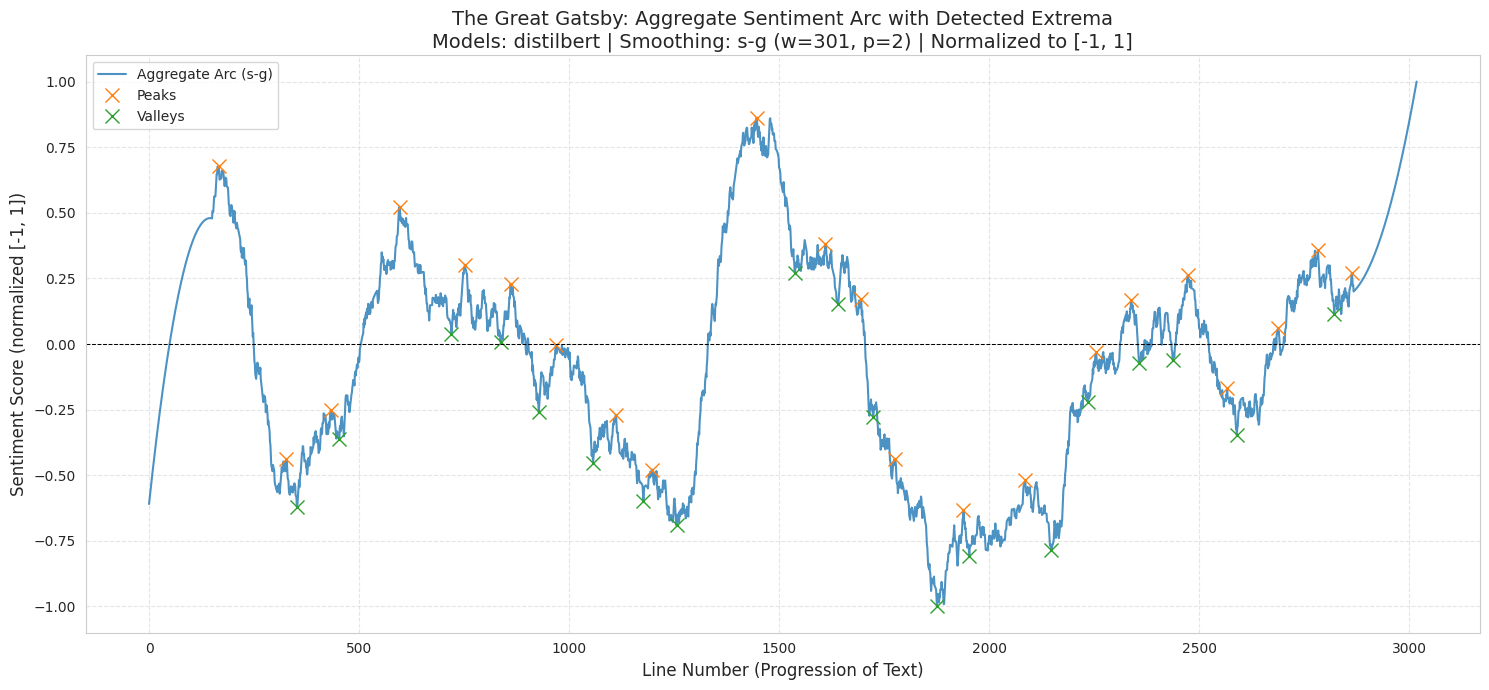

In [ ]:
## STEP #2: Build aggregate arc, detect peaks/valleys, plot, and extract crux text
# (UPDATED: robust normalization + per-line sentiment in crux output)

import json

# Optional: Colab download helper
try:
    from google.colab import files
    COLAB_AVAILABLE = True
except ImportError:
    COLAB_AVAILABLE = False


def apply_ewm_manual(series: pd.Series, span: int, start_value: float = 0.0) -> pd.Series:
    """Manual exponential weighted moving average."""
    alpha = 2.0 / (span + 1.0)
    x_data = series.values
    if len(x_data) == 0:
        return series.copy()

    y_smooth = np.zeros_like(x_data, dtype=float)
    y_smooth[0] = (alpha * x_data[0]) + (1 - alpha) * start_value
    for i in range(1, len(x_data)):
        y_smooth[i] = (alpha * x_data[i]) + (1 - alpha) * y_smooth[i - 1]
    return pd.Series(y_smooth, index=series.index, name=series.name)


def normalize_series_to_minus1_1(series: pd.Series) -> pd.Series:
    """Normalize numeric series to [-1, 1]."""
    vals = series.values.astype(float)
    if len(vals) == 0:
        return series.copy()
    min_val = np.nanmin(vals)
    max_val = np.nanmax(vals)
    val_range = max_val - min_val
    if not np.isfinite(min_val) or not np.isfinite(max_val) or val_range == 0:
        # All identical or invalid -> flat 0.0
        return pd.Series(0.0, index=series.index, name=series.name)
    scaled = -1.0 + ((vals - min_val) * 2.0) / val_range
    return pd.Series(scaled, index=series.index, name=series.name)


print("\n--- Peak & Valley Detection ---")

if not SCIPY_AVAILABLE:
    print("Scipy not available: cannot run Savitzky–Golay or find_peaks. Aborting.")
else:
    try:
        # --- 1. Prepare data & pick sentiment columns ---
        df_sorted = combined_df.sort_values(by="line_no").reset_index(drop=True)
        available_cols = [c for c in df_sorted.columns if c.endswith("_sentiment")]
        if not available_cols:
            raise ValueError("No '*_sentiment' columns found in combined_df.")

        if crux_model_choice == "all":
            # use all model columns that actually exist
            sentiment_columns = [
                MODEL_TO_COL[m] for m in MODEL_TO_COL.keys()
                if MODEL_TO_COL[m] in df_sorted.columns
            ]
            if not sentiment_columns:
                raise ValueError("No matching sentiment columns found for 'all' selection.")
        else:
            sentiment_columns = [MODEL_TO_COL[crux_model_choice]]

        print(f"Using sentiment columns for aggregate arc: {sentiment_columns}")

        # --- 2. Normalize each model to [-1,1], then smooth (if requested) ---
        smoothed_series_list = []
        for col in sentiment_columns:
            # Normalize raw model output to [-1,1]
            y_norm = normalize_series_to_minus1_1(df_sorted[col].astype(float))

            # Apply chosen smoothing to the *normalized* series
            if crux_smoothing_method == "sma":
                y_smooth = y_norm.rolling(
                    window=crux_smoothing_kwargs.get("window_size", 50),
                    center=True,
                    min_periods=1
                ).mean()

            elif crux_smoothing_method == "es":
                y_smooth = apply_ewm_manual(
                    y_norm,
                    span=crux_smoothing_kwargs.get("span", 50),
                    start_value=0.0,
                )

            elif crux_smoothing_method == "s-g":
                wl = crux_smoothing_kwargs.get("window_length", 51)
                po = crux_smoothing_kwargs.get("polyorder", 2)
                y_smooth = pd.Series(
                    savgol_filter(y_norm, wl, po),
                    index=y_norm.index,
                    name=col,
                )

            else:
                raise ValueError(
                    f"Unknown crux_smoothing_method '{crux_smoothing_method}'. "
                    "Valid options: 'sma', 'es', 's-g'."
                )

            smoothed_series_list.append(y_smooth)

        # --- 3. Aggregate across models, then normalize the aggregate ---
        aggregate_df = pd.concat(smoothed_series_list, axis=1)
        aggregate_arc_raw = aggregate_df.mean(axis=1)
        aggregate_arc_raw.name = "aggregate_arc_raw"

        # Final aggregate arc normalized to [-1, 1] (this is what we detect peaks on)
        aggregate_arc = normalize_series_to_minus1_1(aggregate_arc_raw)
        aggregate_arc.name = "aggregate_arc"

        # For fast sentiment lookup by line_no later
        line_numbers = df_sorted["line_no"].values
        agg_norm_lookup = dict(zip(line_numbers, aggregate_arc.values))

        # --- 4. Peak / valley detection on normalized aggregate arc ---
        peak_indices, _ = find_peaks(
            aggregate_arc.values,
            distance=PEAK_DISTANCE,
            prominence=PEAK_PROMINENCE,
        )
        valley_indices, _ = find_peaks(
            -aggregate_arc.values,
            distance=PEAK_DISTANCE,
            prominence=PEAK_PROMINENCE,
        )

        peaks_ls   = line_numbers[peak_indices].tolist()
        valleys_ls = line_numbers[valley_indices].tolist()

        print(f"Peaks found   : {len(peaks_ls)}")
        print(f"Valleys found : {len(valleys_ls)}")

        # --- 5. Plot aggregate arc with detected extrema ---
        main_title = f"{novel_title_author}: Aggregate Sentiment Arc with Detected Extrema"
        subtitle = (
            f"Models: {model_label_pretty} | "
            f"Smoothing: {method_for_label} ({crux_smoothing_param_str}) | "
            "Normalized to [-1, 1]"
        )

        output_plot_filename = (
            f"novel_{novel_title_author}_aggregate_{model_label_short}_{method_for_label}_peaks.png"
        )

        plt.figure(figsize=(15, 7))
        plt.plot(line_numbers, aggregate_arc.values,
                 label=f"Aggregate Arc ({method_for_label})",
                 alpha=0.8)

        if len(peak_indices) > 0:
            plt.plot(
                line_numbers[peak_indices],
                aggregate_arc.values[peak_indices],
                "x",
                markersize=10,
                label="Peaks",
            )
        if len(valley_indices) > 0:
            plt.plot(
                line_numbers[valley_indices],
                aggregate_arc.values[valley_indices],
                "x",
                markersize=10,
                label="Valleys",
            )

        plt.title(main_title + "\n" + subtitle, fontsize=14)
        plt.xlabel("Line Number (Progression of Text)", fontsize=12)
        plt.ylabel("Sentiment Score (normalized [-1, 1])", fontsize=12)
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.axhline(0, color="black", linestyle="--", linewidth=0.75)
        plt.tight_layout()
        plt.savefig(output_plot_filename)
        print(f"Verification plot saved as: '{output_plot_filename}'")

        # --- 6. Crux extraction with per-line normalized sentiment prefix ---
        if not peaks_ls and not valleys_ls:
            print("No peaks or valleys found; skipping text extraction.")
        else:
            print("\nExtracting text windows around crux points...")

            text_lookup = combined_df.set_index("line_no")["text"]
            min_line = combined_df["line_no"].min()
            max_line = combined_df["line_no"].max()

            crux_points = (
                [{"line_no": int(ln), "type": "peak"} for ln in peaks_ls] +
                [{"line_no": int(ln), "type": "valley"} for ln in valleys_ls]
            )
            crux_points_sorted = sorted(crux_points, key=lambda x: x["line_no"])

            json_output = {}
            txt_output_lines = []

            for crux in crux_points_sorted:
                line_no = crux["line_no"]
                crux_type = crux["type"]

                start_line = max(min_line, line_no - CRUX_WINDOW_HALF)
                end_line   = min(max_line, line_no + CRUX_WINDOW_HALF)

                extract_lines_list = []
                for i in range(start_line, end_line + 1):
                    line_text = text_lookup.get(i, "[Text not found]")

                    # look up normalized aggregate sentiment for this line
                    norm_sent = agg_norm_lookup.get(i, np.nan)
                    if norm_sent is None or not np.isfinite(norm_sent):
                        sent_str = "NaN"
                    else:
                        sent_str = f"{norm_sent:+.3f}"

                    # prefix: "line_no: i / sentiment: +0.123 "
                    prefix = f"[Line #{i} ({sent_str})]: "

                    # highlight the crux line by uppercasing its text
                    if i == line_no:
                        extract_lines_list.append(prefix + line_text.upper())
                    else:
                        extract_lines_list.append(prefix + line_text)

                full_extract_str = "\n".join(extract_lines_list)

                json_output[str(line_no)] = {
                    "type": crux_type,
                    "extract": full_extract_str,
                }

                txt_block = (
                    f"line_no: {line_no}\n"
                    f"crux_type: ['{crux_type}']\n"
                    f"crux_extract:\n{full_extract_str}"
                )
                txt_output_lines.append(txt_block)

            base_filename = (
                f"crux_peaks_{novel_title_author}_{model_label_short}_{method_for_label}"
            )
            json_filename = f"{base_filename}.json"
            txt_filename  = f"{base_filename}.txt"

            with open(json_filename, "w", encoding="utf-8") as f:
                json.dump(json_output, f, indent=2)
            with open(txt_filename, "w", encoding="utf-8") as f:
                f.write("\n\n".join(txt_output_lines))

            print(f"Successfully created: {json_filename}")
            print(f"Successfully created: {txt_filename}")

            if COLAB_AVAILABLE:
                print("Initiating file download...")
                files.download(json_filename)
                files.download(txt_filename)
            else:
                print("Files saved in the local directory.")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# **=====[ FIN de Colab ]=====**